### Load Modules

In [3]:
# auto reload modules 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/icewave')

import numpy as np
import os
import glob
import pandas as pd 
import h5py
import pickle
import cv2 as cv

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.path import Path

import scipy.signal as signal
from scipy.interpolate import LinearNDInterpolator, griddata
from datetime import datetime,timedelta
import pytz

from shapely.geometry import Polygon, Point
from scipy.spatial import ConvexHull

import icewave.tools.matlab2python as mat2py
import icewave.sebastien.set_graphs as set_graphs
import icewave.drone.drone_projection as dp
import icewave.tools.matlab_colormaps as matcmaps
import icewave.tools.Fourier_tools as FT
import icewave.tools.rw_data as rw 

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Function section

In [4]:
def transpose_PIVmat_fields(m):
    """ Change dimensions of different fields computed using PIVlab """
    key_fields = ['Vx','Vy','Vz','X','Y']

    for key in key_fields:
        m[key] = np.transpose(m[key])
        
    return m

#--------------------------------------------------------------------------------------

def synchronize_with_all_drones(m,istart = 0, iend = -1):
    """ Keep only data that is common to all drones """
    
    fields_with_time = ['Vx','Vy','Vz']
    for key in fields_with_time:
        m[key] = m[key][:,:,istart:iend]
    
    m['t'] = m['t'][istart:iend]
    
    return m

#---------------------------------------------------------------------------------------


def get_zstar(H,alpha,Y):
    """ Compute distance z_star in the projection geometry (distance between the camera and the plane 
    orthogonal to optical axis and crossing the observed point on the ice, which coordinate is Y in the reference 
    frame work of the drone) 
    
    Inputs : - H, drone height in meter
             - alpha, angle with respect to horizontal (in rad)
             - Y array like or float """
             
    z_star = H/np.sin(alpha) + np.cos(alpha)*Y
    return z_star

# comute system coefficients 

def compute_coeffs(H,alpha,focale,X,Y):
    """ Compute matrix coefficients """
    
    z_star = get_zstar(H, alpha, Y)
    
    a = focale / z_star
    b = -np.cos(alpha)*X*focale/z_star**2
    c = np.sin(alpha)*X*focale/z_star**2
    d = np.zeros(np.shape(X))
    e = (np.sin(alpha) - np.cos(alpha)*np.sin(alpha)*Y/z_star)*focale/z_star
    f = (np.cos(alpha) + np.sin(alpha)*np.sin(alpha)*Y/z_star)*focale/z_star

    coeffs = np.array((a,b,c,d,e,f))
    return coeffs

### Load data from mesange and bernache

In [11]:
# path2data = 'Y:/Banquise/Baptiste/Resultats/Analyse_1102/Data/'
date = '0211'
path2data = f'F:/Rimouski_2024/Data/{date}/Drones/'
drones = ['bernache','mesange']
data = {}
for i in range(len(drones)):
    filelist = glob.glob(f'{path2data}*{drones[i]}/matData/*scaled.mat')    
    file2load = filelist[0]
    with h5py.File(file2load, 'r') as fmat:
        print('Top-level keys : ', list(fmat.keys()))
    
        data[drones[i]] = mat2py.mat_to_dict(fmat['m'],fmat['m'])

Top-level keys :  ['#refs#', '#subsystem#', 'm']
Top-level keys :  ['#refs#', '#subsystem#', 'm']


### Load synchronization file and procruste operations

In [5]:
#%% Load synchro file 
date = '0211'
path2data = f'E:/Rimouski_2024/Data/{date}/Drones/'
filename = f'{path2data}synchro_3drones.pkl'

with open(filename,'rb') as pf:
   synchro = pickle.load(pf)
   
# Synchronize data and structure them
# drone_keys = ['bernache','mesange']
# for key in drone_keys :
#     data[key] = transpose_PIVmat_fields(data[key])
#     istart = synchro[key]
#     data[key] = synchronize_with_all_drones(data[key],istart = istart)
    
#%% Load all procruste operations 
procruste_file = f'{path2data}procruste_operation_i0_520_Nbframes_4000_any_drones.pkl'

with open(procruste_file,'rb') as pf:
    all_op = pickle.load(pf)

# keep the given set of procruste operations 
ref_drone = 'mesange' # drone chosen as reference
projected_drone = 'bernache'

# get drone GPS position and orientation 
file2parameters = f'{path2data}parameters_3drones.pkl'
with open(file2parameters,'rb') as pf :
    param = pickle.load(pf)

### Load buoys tracking position 

In [6]:
file2load = f'{path2data}structure_buoys_tracking_3drones.pkl'
with open(file2load,'rb') as pf:
    Z = pickle.load(pf)

### Plot GPS position seen by both drones 

In [7]:
# Create a colormap for each drone 

maps = {'fulmar':'Blues','bernache':'Oranges','mesange':'Greens'}
maps_drone = {}
for key_drone in maps.keys():
    maps_drone[key_drone] = {}
    full_map = mpl.colormaps[maps[key_drone]].resampled(256)
    new_map = mcolors.ListedColormap(full_map(np.linspace(0.2,1,256)))
    cnorm = mcolors.Normalize(vmin = 0, vmax = 5)
    cnorm_time = mcolors.Normalize(vmin = 0, vmax = Z[key_drone]['t'].max())
    maps_drone[key_drone]['new_map'] = new_map
    maps_drone[key_drone]['cnorm'] = cnorm
    maps_drone[key_drone]['cnorm_time'] = cnorm_time

Text(0.5, 0, 'Longitude')

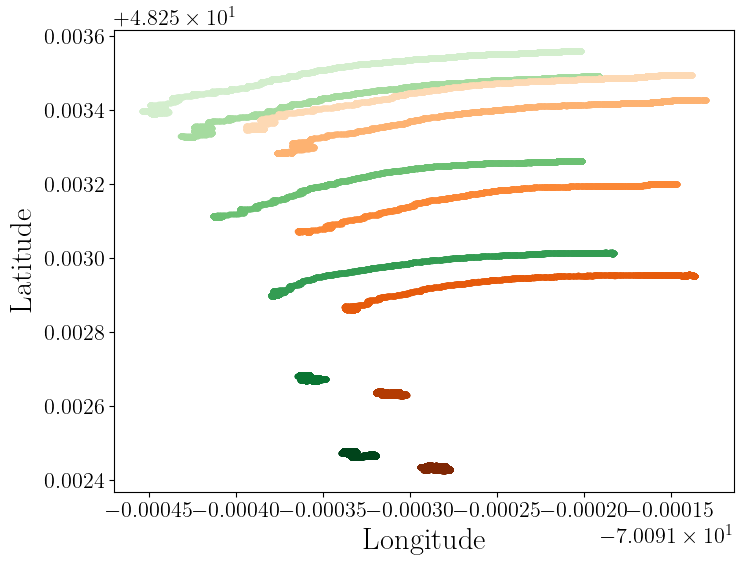

In [8]:
set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots()   

for drone_key in ['mesange','bernache']:
    for i in range(6): 
        current_color = maps_drone[drone_key]['new_map'](maps_drone[drone_key]['cnorm'](i))
        ax.plot(Z[drone_key]['GPS'][i,1,:],Z[drone_key]['GPS'][i,0,:],'.',color = current_color) 
        
ax.set_ylabel(r'Latitude')
ax.set_xlabel(r'Longitude')

### Adjust drone parameters

In [36]:
projected_drone = 'bernache'
ref_drone = 'mesange'
Nb_buoys = 5
Nb_frames = 4000
i0 = 520

# compute adjustement of azimuth angle 
corrections = {projected_drone : {}, ref_drone : {}}
for drone_key in corrections.keys():
    corrections[drone_key]['lambda_phi'] = np.zeros(np.shape(Z[drone_key]['GPS'][:Nb_buoys,:,i0:i0 + Nb_frames]))
    corrections[drone_key]['lambda_phi'][:,0,:] = Z[drone_key]['GPS'][:Nb_buoys,0,i0:i0 + Nb_frames] - param[projected_drone]['latitude']
    corrections[drone_key]['lambda_phi'][:,1,:] = (Z[drone_key]['GPS'][:Nb_buoys,1,i0:i0 + Nb_frames] 
                                              - param[projected_drone]['longitude'])*np.cos(param[projected_drone]['latitude'])

Text(0.5, 0, '$\\cos(\\lambda_0)(\\phi - \\phi_0)$')

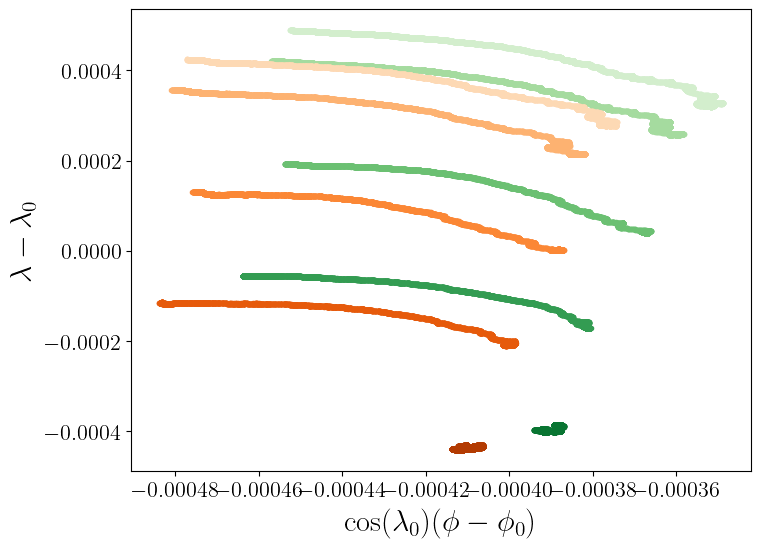

In [37]:
set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots()   

for drone_key in ['mesange','bernache']:
    for i in range(Nb_buoys): 
        current_color = maps_drone[drone_key]['new_map'](maps_drone[drone_key]['cnorm'](i))
        ax.plot(corrections[drone_key]['lambda_phi'][i,1,:],corrections[drone_key]['lambda_phi'][i,0,:],'.',color = current_color) 
        
ax.set_ylabel(r'$\lambda - \lambda_0$')
ax.set_xlabel(r'$\cos(\lambda_0)(\phi - \phi_0)$')

### Compute best translation / rotation over the whole trajectory

In [82]:
mean_op = {}
output_rescaling = 0
Nb_buoys = 5
Nb_frames = 4000
i0 = synchro['mesange']
for drone_key in ['mesange','bernache']:
    selected_Z = Z[drone_key]['GPS'][:Nb_buoys,:,i0:i0 + Nb_frames].transpose(0,2,1)
    selected_Z = np.array([selected_Z[:,:,0].ravel(),selected_Z[:,:,1].ravel()])

for ref_drone in ['bernache', 'mesange']:
    for projected_drone in ['bernache', 'mesange']:
        if projected_drone != ref_drone:
            key_procruste = f'{projected_drone}_2_{ref_drone}'

            current_op = {}
            current_op['ref_drone'] = ref_drone
            current_op['projected_drone'] = projected_drone

            points = {}
            for drone_key in [ref_drone,projected_drone]:
                i0 = synchro[drone_key]
                selected_Z = Z[drone_key]['GPS'][:Nb_buoys,:,i0:i0 + Nb_frames].transpose(0,2,1)
                selected_Z = np.array([selected_Z[:,:,0].ravel(),selected_Z[:,:,1].ravel()]).T
                current_points = np.zeros(selected_Z.shape)
                current_points[:,0] = selected_Z[:,0] - param[projected_drone]['latitude']
                current_points[:,1] = (selected_Z[:,1] 
                                       - param[projected_drone]['longitude'])*np.cos(param[projected_drone]['latitude'])
                points[drone_key] = current_points

            scaling,R,t = FT.procrustes_alignement(points[projected_drone],points[ref_drone],output_rescaling)
            current_op['scaling'] = scaling
            current_op['rot'] = R
            current_op['translat'] = t

            mean_op[key_procruste] = current_op
            print(f'Operations for {key_procruste} computed')

Operations for mesange_2_bernache computed
Operations for bernache_2_mesange computed


In [33]:
file2save = f'{path2data}avg_procruste_operation_i0_520_Nbframes_{Nb_frames}_mesange_bernache_lambda_phi.pkl'
with open(file2save,'wb') as pf :
    pickle.dump(mean_op,pf)
    print(f'{file2save} saved !')

h52save = f'{path2data}avg_procruste_operation_i0_520_Nbframes_{Nb_frames}_mesange_bernache_lambda_phi.h5'
rw.save_dict_to_h5(mean_op,h52save)

E:/Rimouski_2024/Data/0211/Drones/avg_procruste_operation_i0_520_Nbframes_4000_mesange_bernache_lambda_phi.pkl saved !


### Compute angle correction and drone height

In [83]:
ref_drone = 'mesange'
projected_drone = 'bernache'
key_op = f'{projected_drone}_2_{ref_drone}'

delta_psi = np.arccos(mean_op[key_op]['rot'][0,0])
print(delta_psi*180/np.pi)

delta_lat = mean_op[key_op]['translat'][0]
delta_long = np.cos(param[projected_drone]['latitude'])*mean_op[key_op]['translat'][1]
print(delta_lat, delta_long)

0.6863219361066616
4.3319425005931994e-05 -1.0013292280801123e-05


### Show resulting alignement 

In [84]:
lambda_phi_transfo = np.zeros(Z[ref_drone]['GPS'][:Nb_buoys,:,i0:i0 + Nb_frames].shape)

R = mean_op[key_op]['rot']
t = mean_op[key_op]['translat']
scaling = mean_op[key_op]['scaling']

for i in range(Nb_frames):
    lambda_phi_transfo[:,:,i] = scaling * (R @ corrections[projected_drone]['lambda_phi'][:Nb_buoys,:,i].T).T + t

Text(0.5, 0, '$\\cos(\\lambda_0)(\\phi - \\phi_0)$')

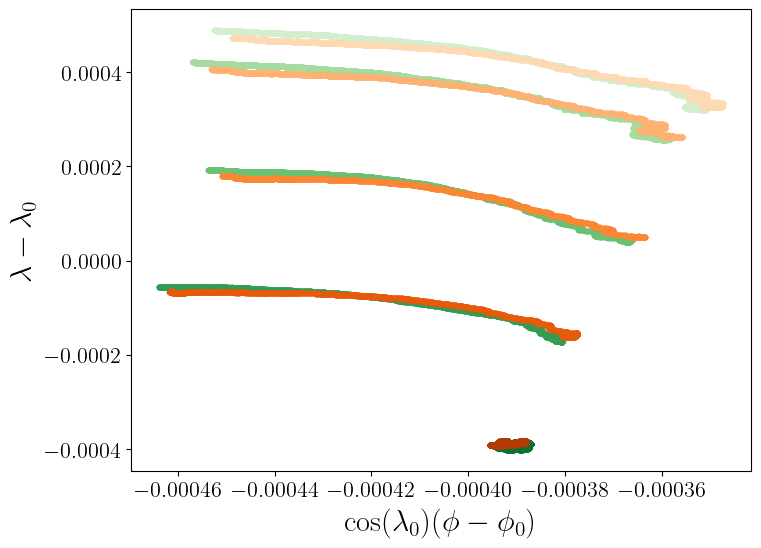

In [85]:
set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots()   

for drone_key in ['mesange','bernache']:
    if drone_key == ref_drone:
        for i in range(Nb_buoys): 
            current_color = maps_drone[drone_key]['new_map'](maps_drone[drone_key]['cnorm'](i))
            ax.plot(corrections[drone_key]['lambda_phi'][i,1,:],corrections[drone_key]['lambda_phi'][i,0,:],'.',color = current_color) 
    else :
        for i in range(Nb_buoys): 
            current_color = maps_drone[drone_key]['new_map'](maps_drone[drone_key]['cnorm'](i))
            ax.plot(lambda_phi_transfo[i,1,:],lambda_phi_transfo[i,0,:],'.',color = current_color) 
        
ax.set_ylabel(r'$\lambda - \lambda_0$')
ax.set_xlabel(r'$\cos(\lambda_0)(\phi - \phi_0)$')

### Converts coordinates from one drone to an other using these parameters adjustments

In [86]:
ref_drone = 'mesange'
projected_drone = 'bernache'
key_op = f'{projected_drone}_2_{ref_drone}'

# compute reduced GPS coordinates
corrections = {projected_drone : {}, ref_drone : {}}
for drone_key in corrections.keys():
    corrections[drone_key]['lambda_phi'] = np.zeros(np.shape(Z[drone_key]['GPS'][:Nb_buoys,:,i0:i0 + Nb_frames]))
    corrections[drone_key]['lambda_phi'][:,0,:] = Z[drone_key]['GPS'][:Nb_buoys,0,i0:i0 + Nb_frames] - param[projected_drone]['latitude']
    corrections[drone_key]['lambda_phi'][:,1,:] = (Z[drone_key]['GPS'][:Nb_buoys,1,i0:i0 + Nb_frames] 
                                              - param[projected_drone]['longitude'])*np.cos(param[projected_drone]['latitude'])

# apply rotation and translation
lambda_phi_transfo = np.zeros(Z[ref_drone]['GPS'][:Nb_buoys,:,i0:i0 + Nb_frames].shape)

R = mean_op[key_op]['rot']
t = mean_op[key_op]['translat']
scaling = mean_op[key_op]['scaling']

for i in range(Nb_frames):
    lambda_phi_transfo[:,:,i] = scaling * (R @ corrections[projected_drone]['lambda_phi'][:Nb_buoys,:,i].T).T + t

# Back to GPS coordinates
latlong_transfo = np.zeros(lambda_phi_transfo.shape)
latlong_transfo[:,0,:] = lambda_phi_transfo[:,0,:] + param[projected_drone]['latitude']
latlong_transfo[:,1,:] = lambda_phi_transfo[:,1,:]/np.cos(param[projected_drone]['latitude']) + param[projected_drone]['longitude']

# Compute back to X,Y coordinate system associated to ref_drone 
param_ref = param[ref_drone]
dist2drone = param_ref['h']/np.tan(param_ref['alpha_0'])
Lat_ref = param_ref['latitude']
Long_ref = param_ref['longitude']
azimuth_ref = param_ref['azimuth']
Lat0,Long0 = dp.LatLong_coords_from_referencepoint(Lat_ref,Long_ref,
                                                azimuth_ref,dist2drone)
latlong_transfo = latlong_transfo.transpose(0,2,1)

X_proj,Y_proj = dp.GPS2XY(latlong_transfo[:,:,0],latlong_transfo[:,:,1],Lat0,Long0,azimuth_ref)

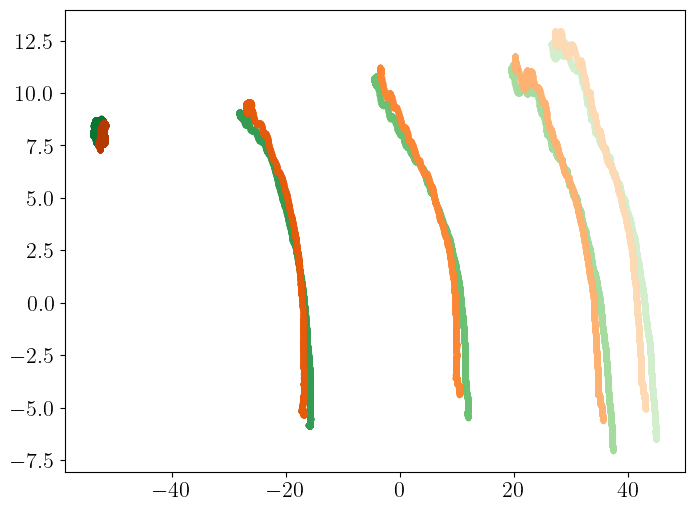

In [87]:
fig, ax = plt.subplots()
for drone_key in ['mesange','bernache']:
    if drone_key == ref_drone:
        for i in range(Nb_buoys): 
            current_color = maps_drone[drone_key]['new_map'](maps_drone[drone_key]['cnorm'](i))
            ax.plot(Z[ref_drone]['real'][i,0,:],Z[ref_drone]['real'][i,1,:],'.',color = current_color) 
    else :
        for i in range(Nb_buoys): 
            current_color = maps_drone[drone_key]['new_map'](maps_drone[drone_key]['cnorm'](i))
            ax.plot(X_proj[i,:],Y_proj[i,:],'.',color = current_color) 
        

### Compute mean distance between trajectories

Text(0.5, 0, 'Time step')

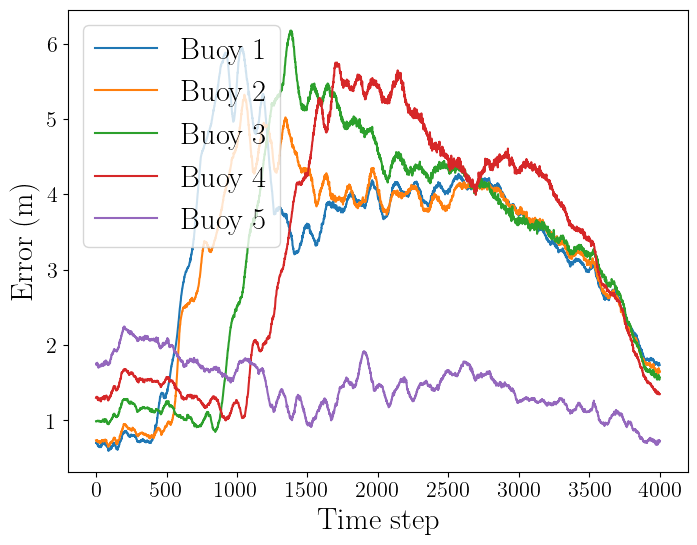

In [88]:
Xref = Z[ref_drone]['real'][:Nb_buoys,0,:Nb_frames]
Yref = Z[ref_drone]['real'][:Nb_buoys,1,:Nb_frames]

error = np.sqrt((X_proj - Xref)**2 + (Y_proj - Yref)**2)

set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots()
for i in range(5):    
    label_buoy = f'Buoy {i+1}'
    ax.plot(error[i,:],label = label_buoy)

ax.legend()
ax.set_ylabel(r'Error (m)')
ax.set_xlabel(r'Time step')

### Conclusion : The reorientation operations are more efficient as we achieved using procruste analysis frame by frame, by computing each operation using buoys GPS position, without interpreting translations, rotations and rescaling by relevant parameters of the problem (H, $\psi$, $\lambda_0$, $\phi_0$). 

### The correction of drone orientation is negligeable.

# Old section - old version of procruste analysis

In [42]:
print(Z['bernache']['GPS'][0,:,0])

[ 48.25335018 -70.09138884]


In [9]:
mean_op = {}
output_rescaling = 0
Nb_buoys = 5
Nb_frames = 4000
for ref_drone in ['bernache', 'mesange']:
    for projected_drone in ['bernache', 'mesange']:
        if projected_drone != ref_drone:
            key_procruste = f'{projected_drone}_2_{ref_drone}'

            current_op = {}
            current_op['ref_drone'] = ref_drone
            current_op['projected_drone'] = projected_drone

            points = {}
            for drone_key in [ref_drone,projected_drone]:
                i0 = synchro[drone_key]
                current_points = Z[drone_key]['GPS'][:Nb_buoys,:,i0:i0 + Nb_frames]
                current_points = current_points.transpose(0,2,1)
                current_points = np.array([current_points[:,:,0].ravel(),current_points[:,:,1].ravel()])
                points[drone_key] = current_points

            scaling,R,t = FT.procrustes_alignement(points[projected_drone],points[ref_drone],output_rescaling)
            current_op['scaling'] = scaling
            current_op['rot'] = R
            current_op['translat'] = t

            mean_op[key_procruste] = current_op



MemoryError: 

### Show resulting alignement

In [ ]:
latlong_transfo = np.zeros(Z[ref_drone]['GPS'][:Nb_buoys,:,i0:i0 + Nb_frames].shape)

ref_drone = 'mesange'
projected_drone = 'bernache'
key_op = f'{projected_drone}_2_{ref_drone}'

R = mean_op[key_op]['rot']
t = mean_op[key_op]['translat']
scaling = mean_op[key_op]['scaling']

for i in range(Nb_frames):
    latlong_transfo[:,:,i] = scaling * (R @ Z[projected_drone]['GPS'][:Nb_buoys,:,i0 + i].T).T + t



In [ ]:
set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots()   

for drone_key in [ref_drone,projected_drone]:
    if drone_key == ref_drone:
        for i in range(5): 
            current_color = maps_drone[drone_key]['new_map'](maps_drone[drone_key]['cnorm'](i))
            ax.plot(Z[drone_key]['GPS'][i,1,:],Z[drone_key]['GPS'][i,0,:],'.',color = current_color) 
    else :
        for i in range(5): 
            current_color = maps_drone[drone_key]['new_map'](maps_drone[drone_key]['cnorm'](i))
            ax.plot(latlong_transfo[i,1,:],latlong_transfo[i,0,:],'.',color = current_color) 
        
ax.set_ylabel(r'Latitude')
ax.set_xlabel(r'Longitude')

### Save mean operations

In [ ]:
file2save = f'{path2data}avg_procruste_operation_i0_520_Nbframes_{Nb_frames}_mesange_bernache.pkl'
with open(file2save,'wb') as pf :
    pickle.dump(mean_op,pf)
    print(f'{file2save} saved !')

h52save = f'{path2data}avg_procruste_operation_i0_520_Nbframes_{Nb_frames}_mesange_bernache.pkl'
rw.save_dict_to_h5(mean_op,h52save)


In [36]:
synchro

{'fulmar': 0, 'mesange': 520, 'bernache': 520}

In [42]:
test = Z['mesange']['GPS'].transpose(0,2,1)
test = np.array([test[:,:,0].ravel(),test[:,:,1].ravel()])
print(test)

[[ 48.25339026  48.25339026  48.25339026 ...  48.25247314  48.25247314
   48.25247314]
 [-70.09144796 -70.09144796 -70.09144796 ... -70.09133171 -70.09133171
  -70.09133171]]


### Show evolution of rotation / translation /rescaling coefficients with time 

In [14]:
key_op = f'{projected_drone}_2_{ref_drone}'
print(all_op[key_op].keys())

dict_keys(['i0', 'Nb_frames', 'ref_drone', 'projected_drone', 'scaling', 'rot', 'translat'])


Text(0, 0.5, '$P_{01}$')

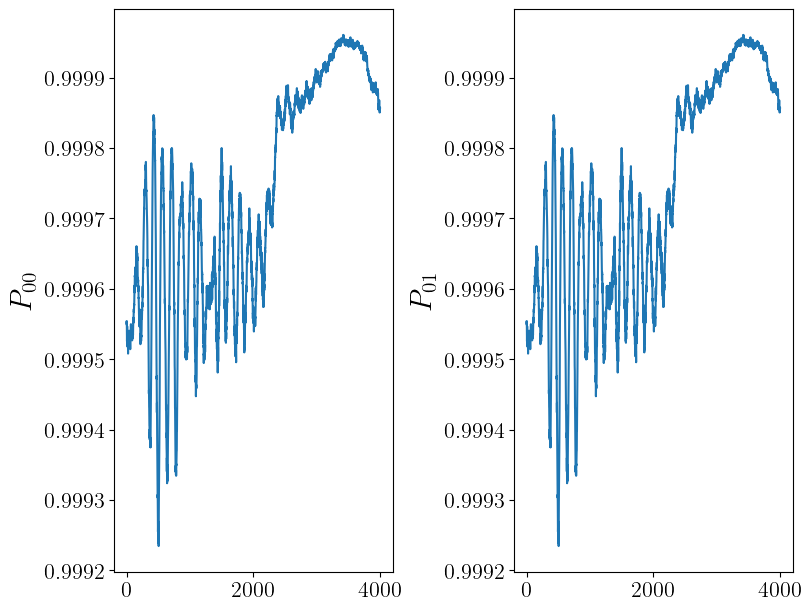

In [27]:
set_graphs.set_matplotlib_param('single')
fig, axs = plt.subplots(ncols = 2, layout = 'constrained')
axs[0].plot(all_op[key_op]['rot'][0,0])
axs[1].plot(all_op[key_op]['rot'][0,0])

axs[0].set_ylabel(r'$P_{00}$')
axs[1].set_ylabel(r'$P_{01}$')

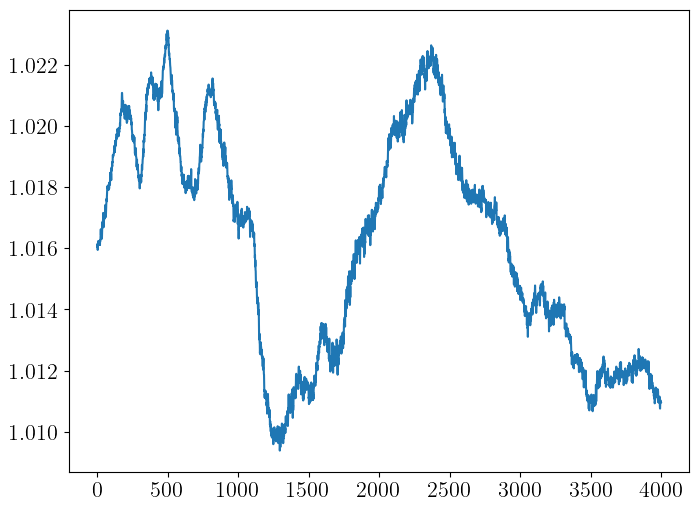

In [28]:
fig, ax = plt.subplots()
ax.plot(all_op[key_op]['scaling'])
ax.set_ylabel(r'scaling')
ax.set_title(r'')

In [30]:
all_op[key_op]['translat'].shape

(2, 4000)

Text(0.5, 1.0, 'Translation coeff')

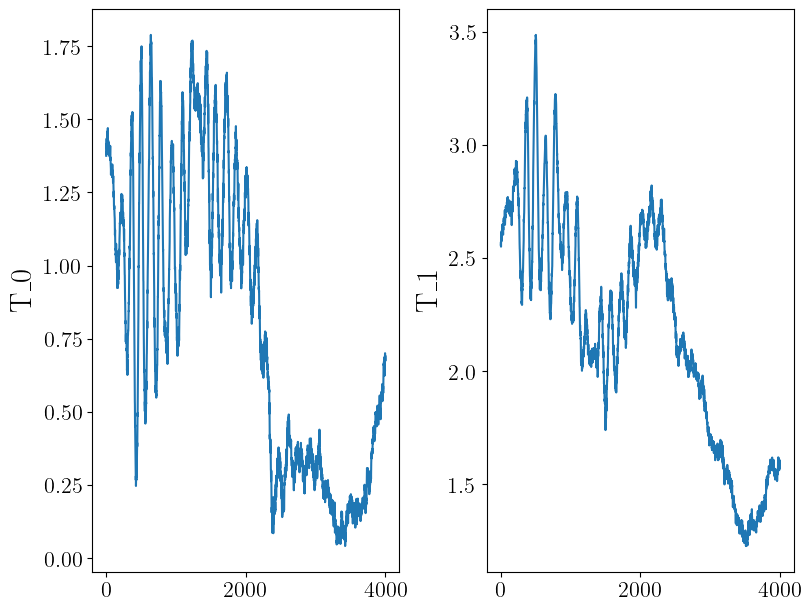

In [32]:
fig, axs = plt.subplots(ncols = 2, layout = 'constrained')
axs[0].plot(all_op[key_op]['translat'][0,:])
axs[0].set_ylabel(r'T_0')
axs[1].plot(all_op[key_op]['translat'][1,:])
axs[1].set_ylabel(r'T_1')
ax.set_title(r'Translation coeff')